In [16]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [17]:
from typing import Annotated
from typing_extensions import TypedDict

In [18]:
!pip install arxiv wikipedia

In [19]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

#tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)
wikipedia_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wikipedia_tool=WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [20]:
wikipedia_tool.invoke("who is Salman Khan?")

"Page: Salman Khan\nSummary: Abdul Rashid Salim Salman Khan (pronounced [səlˈmɑːn xɑːn]; born 27 December 1965) is an Indian actor, film producer, and television personality who predominantly works in Hindi films. In a career spanning over three decades, Khan's awards, include two National Film Awards"

In [21]:
wikipedia_tool.invoke("who is Sundar pichai?")

'Page: Sundar Pichai\nSummary: Pichai Sundararajan (born June 10, 1972), better known as Sundar Pichai, is an Indian-born American business executive. He is the chief executive officer (CEO) of Alphabet Inc. and its subsidiary Google.\nPichai began his career as a materials engineer. Following a short '

In [22]:
arxiv_tool.invoke('Attention is all you need')

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [23]:
tools = [wikipedia_tool]

In [24]:
# Langgrsph Application
from langgraph.graph.message import add_messages
class State (TypedDict):
  messages:Annotated[list, add_messages]


In [25]:
from langgraph.graph import StateGraph, START, END

In [26]:
graph_builder = StateGraph(State)

In [27]:
from langchain_groq import ChatGroq

In [28]:
from google.colab import userdata
groq_api_key=userdata.get('groq_api_key')

In [30]:
#llm= ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It"

llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7bf5bae00350>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7bf5b9f6aed0>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [31]:
llm_with_tools=llm.bind_tools(tools=tools)

In [32]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [33]:
from langgraph.prebuilt import ToolNode, tools_condition

In [34]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
     "chatbot",
     tools_condition
  )
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)


In [35]:
graph=graph_builder.compile()

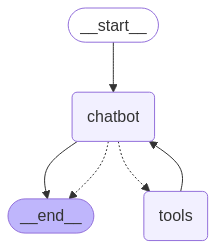

In [36]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass


In [39]:
user_input="Hi, my name is sundar"

events=graph.stream(
    {"messages":[("user", user_input)]}, stream_mode="values"
)

for event in events:
 event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is sundar


APIConnectionError: Connection error.